In [53]:
import numpy as np
import scipy
import matplotlib.pyplot as plt 
from numpy.linalg import eig
import matplotlib.animation as animation
from IPython.display import clear_output
import subprocess
import random
from datetime import datetime

In [54]:
def getXY(BG_in):
    # Define the command to run the compiled C++ executable
    executable_path = r'C:\Users\jmcc0\Desktop\FYP\Frank code\getXY.exe'
    run_command = [executable_path]

    # Run the compiled C++ code
    process = subprocess.Popen(run_command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, cwd=r'C:\Users\jmcc0\Desktop\FYP\Frank code')

    # Provide input to the C++ program
    BG = BG_in
    process.stdin.write(str(BG).encode())
    process.stdin.close()

    # Read the output from the C++ program
    output = process.stdout.read().decode().strip()
    x_str, y_str = output.split('\t')
    x = float(x_str.split('=')[1])
    y = float(y_str.split('=')[1])
    # Now you have the x and y values from the C++ code
    print("x =", x)
    print("y =", y)
    
    return x, y

def getGap(layers):
    with open('input.txt', 'w') as f:
        f.write(str(int(len(layers))) + "\n")
        for layer in layers:
            f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
    with open('materials.txt', 'w') as f:
        for material in materials:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        for material in alloys:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    
    executable_path = r'C:\Users\jmcc0\Desktop\FYP\QWI\getGap.exe'
    run_command = [executable_path]
    process = subprocess.Popen(run_command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, cwd=r'C:\Users\jmcc0\Desktop\FYP\QWI')
    
    output = process.stdout.read().decode().strip()
    lines = output.split('\n')

    # Initialize variables to store the values
    energy_e = None
    energy_lh = None
    energy_hh = None

    # Process each line
    for line in lines:
        parts = line.split(':')
        if len(parts) == 2:  # Ensure the line has a label and a value
            label = int(parts[0])
            value = float(parts[1])
            if label == 0:
                energy_e = value
            elif label == 1:
                energy_lh = value
            elif label == 2:
                energy_hh = value
    
    return max(1240/abs(energy_e-energy_lh), 1240/abs(energy_e-energy_hh))

# voigt function details
num_discrete = 2048
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2
gamma = 50
sigma = gamma
PLOT_LIMIT=[]

def pad_func_zeros(func):
    func_new = np.zeros(2*len(func))
    j = 0
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    return func_new # twice in length

def pad_func_linear(func):
    func_new = np.zeros(2*len(func))
    j = 0
    del_f = np.abs(func[1]-func[2])
    for i in range(0, int(0.25*len(func_new))):
        func_new[i] = func[0]-0.5*(func[len(func)-1]-func[0]) + i*del_f
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    w=j-1
    j=1
    for i in range(int(0.75*len(func_new)), len(func_new)):
        func_new[i] = func[w] + j*del_f
        j+=1
    return func_new # twice in length

def pad_E(f):
    del_f = np.max(f)/(num_discrete-1)
    func_new = np.zeros(2*len(f))
    j = 0
    for i in range(len(func_new)):
        func_new[i] = del_f*i
    return func_new # twice in length

def convolve(f, g): # PAD ARRAYS BEFORE USE FRO ABSORPTION
    FFT_f = np.fft.fft(f)
    FFT_g = np.fft.fft(g)
    FG = FFT_f * FFT_g
    result = np.fft.ifft(FG)
    return np.real(result)

# plotting
PLOT_LIMIT = []#400,800]
Y_LIMIT = [] # leave blank for auto
ERROR_BARS = False
PLOT_FITTED = False
split_ = ","
LABEL_FONT_SIZE = 13
TICK_FONT_SIZE = 11
LINE_WIDTH = 0.5
MARKER_SIZE = 1
LEGEND = True
label_x = ""
label_y = ""
plot_title = ""
aspect_ratio = [5,5]

colours = [ 'black', 'dimgrey', 'lightslategrey', 'lightsteelblue', 'silver', 'cadetblue', 'darkcyan', 'darkslategray', 'seagreen', 'mediumseagreen', 'darkolivegreen', 'olivedrab', 'olive', 'yellowgreen', 'green', 'springgreen', 'mediumspringgreen', 'turquoise', 'lightseagreen']

def plot_graph(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (aspect_ratio[0],aspect_ratio[1])
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize = TICK_FONT_SIZE)
    plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    plt.plot(x, y, linewidth = LINE_WIDTH, color = 'dimgrey', marker = 's', markersize = MARKER_SIZE, markerfacecolor='dimgrey')
    plt.grid(True, alpha=0.2)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def plot_graphs(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE, color = colours[i])
        else:
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()
    
def plot_graphs_distinct(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x[i], ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE, color = colours[i])
        else:
            plt.plot(x[i], ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def make_array(y, number_steps):
    p = np.zeros(number_steps)
    for nr in range(0, number_steps):
        p[nr] = y
    return p

def read_in(file_path):
    x_data_ = []
    y_data_ = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line into x and y values
                x_val, y_val = map(float, line.strip().split())
                x_data_.append(x_val)
                y_data_.append(y_val)
    except FileNotFoundError:
        print("File not found:", file_path)

    # Convert lists to numpy arrays
    x_array_ = np.array(x_data_)
    y_array_ = np.array(y_data_)
    
    #plot_graph(x_array_, y_array_)
    
    return x_array_, y_array_

In [55]:
def write_simulation_parameters(inter_mixing_params, num_electric_fields, max_electric_field):
    with open('simulation_parameters.txt', 'w') as f:
        f.write(f"{inter_mixing_params[0]} {inter_mixing_params[1]}\n")
        f.write(f"{num_electric_fields}\n")
        f.write(f"{max_electric_field}\n")

class Layer:
    def __init__(self, material, thickness): # thickness in [A]
        self.material = material
        self.thickness = thickness

class Material:
    def __init__(self, name, affinity, band_gap, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive):
        self.affinity = affinity
        self.band_gap = band_gap
        self.e_eff_mass = e_eff_mass
        self.lh_eff_mass = lh_eff_mass
        self.hh_eff_mass = hh_eff_mass
        self.name = name
        self.refractive = refractive
        
    def getEffectiveMass(self, p):
        if p == 0:
            return self.e_eff_mass
        if p == 1:
            return self.lh_eff_mass
        if p == 2:
            return self.hh_eff_mass
        
    def getBandgap(self):
        return self.band_gap
    
    def getRefractive(self):
        return self.refractive
    
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.063, 0.082, 0.51, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.14, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.026, 0.41, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []
def BG_InGaAlAs(x, y):
    return 0.36 + 2.093*y + 0.629*x + 0.577*y*y + 0.436*x*x + 1.013*x*y - 2.0*x*y*(1-x-y); # [eV]
def EF_InGaAlAs(x, y): # Effective electron finity for placing conduction bands InGaAlAs
    return 0.5766 - 0.3439*BG_InGaAlAs(x, y) # [eV]
def effMass_InGaAlAs(x, y, particle):
    return InAs.getEffectiveMass(particle)*(1-x-y) + GaAs.getEffectiveMass(particle)*(x) + AlAs.getEffectiveMass(particle)*(y);
def refractive_InGaAlAs(x, y):
    E_g = BG_InGaAlAs(x,y);
    x=(E_g-0.75)/0.72;
    w = 1240/E_g
    if (x>1.0): x = 1
    A = 9.689 - 1.012*x;
    B = 1.590 - 0.376*x;
    C = 1102.4 - 702.0*x + 330.4*x*x;
    if (C+100 < w):
        X = w*w-C*C
    else: 
        X = (200*w+10000)
    return np.sqrt(A + B*w*w/X);
def InGaAlAs_material(bandgap): # in nm
    bandgap = 1240/bandgap
    x, y = getXY(bandgap)
    temp = Material("In{}Ga{}Al{}As".format(1-x-y,x,y), EF_InGaAlAs(x, y), BG_InGaAlAs(x, y), effMass_InGaAlAs(x, y, 0), effMass_InGaAlAs(x, y, 1), effMass_InGaAlAs(x, y, 2), refractive_InGaAlAs(x,y))
    print(BG_InGaAlAs(x, y))
    alloys.append(temp)
    return temp

def findAlloys(layers, target):
    sigma = 2500
    sigma0 = 500
    sigma_prev = sigma0
    i = 0
    while i < 20:
        for layer in layers:
            if layer.material.name != 'InP':  # Exclude InP layers from modification
                old_bandgap = 1240/layer.material.band_gap
                new_bandgap = old_bandgap + (target - getGap(layers))  # Adjust each layer's bandgap individually
                layer.material = InGaAlAs_material(new_bandgap)
        with open('input.txt', 'w') as f:
            f.write(str(int(len(layers))) + "\n")
            for layer in layers:
                f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

        with open('materials.txt', 'w') as f:
            for material in materials:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
            for material in alloys:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

        testGap = getGap(layers)
        temp = sigma
        print(testGap)
        if testGap > target + 1:
            sigma = (sigma0 + sigma) / 2.0
            sigma_prev = temp
        elif testGap < target - 1:
            sigma0 = sigma
            sigma = (sigma_prev + sigma) / 2.0
        else:
            break
        i += 1
    if(i>=20): success = False
    else: success = True
    print("out: " + str(testGap))
    return layers, success

In [56]:
class Heterostructure: 
    layers = np.empty(0, dtype=Layer)
    conduction_potential = np.empty(0, dtype=float)
    valence_potential = np.empty(0, dtype=float)
    heterostructure_thickness = 0.0
    
    def __init__(self, layers): # thickness in [nm]
        self.layers = layers
        self.conduction_potential = np.array(0)
        self.valence_potential = np.array(0)
        total_thickness = 0
        for layer in self.layers:
            total_thickness += layer.thickness
        self.heterostructure_thickness = total_thickness
        #self.set_potentials()
        
    def add_layer(self, layer):
        self.layers.append(layer)
        #set_potentials()
        
    def clear_layers(self):
        self.layers.clear()
                
    def potential(self, particle, x): # potential as a function of x inside the structure (specific band energy)
        material_threshold = 0.0
        U = 0.0
        V = 0.0
        i = 0
        
        for layer in self.layers:
            material_threshold += layer.thickness
            if x >= material_threshold:
                if(over_ride_offsets == False):
                    U += CBO(self.layers[i].material, self.layers[i+1].material)
                    V += VBO(self.layers[i].material, self.layers[i+1].material)
                elif(over_ride_offsets == True):
                    U += CBO_override[i]
                    V += VBO_override[i]
                i = i + 1
            else: # if used correctly, there should never be an error here (one might occur when an x input is out of analysis bounds)
                if particle == 1 or particle == 2: # if particle is hole
                    return V - electron_charge*electric_field*(x-self.heterostructure_thickness/2.0)  
                elif particle == 0:                # else it is electron
                    return U + electron_charge*electric_field*(x-self.heterostructure_thickness/2.0)
                
    def eff_mass(self, particle, x): # get effective mass for material at x in semiconductor wafer
        material_threshold = 0.0
        for layer in self.layers:
            material_threshold += layer.thickness
            if x <= material_threshold:
                if particle == 'hh':
                    return layer.material.hh_eff_mass
                if particle == 'lh':
                    return layer.material.lh_eff_mass
                if particle == 'e':
                    return layer.material.e_eff_mass

def VBO(material1, material2): # Conduction Band Offset [eV] between 2 materials
    return (material1.affinity - material2.affinity)

def CBO(material1, material2): # Valence Band Offset [eV] between 2 materials
    calc1 = material1.affinity + material1.band_gap
    calc2 = material2.affinity + material2.band_gap
    return (calc2 - calc1)

In [81]:
layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer6 = Layer(GaP, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1200), 30)
layer3 = Layer(InGaAlAs_material(1549.81), 90)
layer5 = Layer(InGaAlAs_material(1549.81), 90)
layer4 = Layer(InGaAlAs_material(1239.85), 30)
InP_layer2 = Layer(InGaAlAs_material(1239.85), 100)
# layer3 = Layer(InGaAlAs_material(1400.81), 30)
InP_layer = Layer(InGaAlAs_material(1239.85), 100)

# layers = [InP_layer, layer3, layer4, layer5, layer4, layer3, InP_layer]
layers = [InP_layer2, layer3, InP_layer2]
QW = Heterostructure(layers)

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 20 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])

x = 0.250731
y = 0.220956
1.0333334315677287
x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.27263
y = 0.198688
1.0001199377038916
x = 0.27263
y = 0.198688
1.0001199377038916
x = 0.27263
y = 0.198688
1.0001199377038916
Initial Bandgap: 1470.3040090684556


In [58]:
# General Parameters
mass_electron = 9.109534e-31 # 1.0 # [kg]
hbar = 6.582119569e-16 # [eV s] source: wikipedia
# length = 100.0 # [??]
number_steps = 5000
electric_field = 0 #0.01 # Electric field [V/nm]
electron_charge = 1 #1.60217663e-19 # [C]
over_ride_offsets = False
hbar_squared_2m = 3.81 #eV angstrom squared

In [59]:
# Solution to Finite Potential Well (Schrodinger Equation in 1D: Finite Potential Within an Infinite Well)

p = 0 # p = 0 : ELECTRON CALCULATION TEST

M = np.zeros((number_steps, number_steps))
x = np.zeros(number_steps)

dy = 1.0 / QW.heterostructure_thickness


delta_x = QW.heterostructure_thickness / (number_steps + 1.0)
C = hbar_squared_2m * 1.0/(delta_x*delta_x)

x[0] = delta_x

alpha_w = np.zeros(number_steps)
alpha_e = np.zeros(number_steps)
alpha_x = np.zeros(number_steps)

particle = ['e', 'lh', 'hh']

electric_field = 0.000

alpha_w[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[0]))
alpha_e[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[1]))
alpha_x[0] = -alpha_w[0]-alpha_e[0]

M[0][0] = alpha_x[0] + QW.potential(p,x[0])
M[0][1] = alpha_e[0]

for nr in range(0, number_steps):
    x[nr] = x[0] + nr*delta_x

for nr in range(1, number_steps-1): #range runs from 1 to num_steps-2 (stupid python syntax)
    alpha_w[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr-1]))
    alpha_e[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr+1]))
    alpha_x[nr] = -alpha_w[nr]-alpha_e[nr]

    M[nr][nr-1] = alpha_w[nr]    #sub-diagonal
    M[nr][nr] = alpha_x[nr] + QW.potential(p,x[nr]) #diagonal
    M[nr][nr+1] = alpha_e[nr]   #upper diagonal 

alpha_w[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1-1]))
alpha_e[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1])) # assuming m(x_edge-dx) = m(x_edge) as boundary condition
alpha_x[number_steps-1] = -alpha_w[number_steps-1]-alpha_e[number_steps-1]
M[number_steps-1][number_steps-2] = alpha_w[number_steps-1]
M[number_steps-1][number_steps-1] = alpha_x[number_steps-1] + QW.potential(p,x[number_steps-1])

w,v=eig(M)
idx = np.argsort(w)
w = w[idx]
v = v[:,idx]

_1 = w[0]

print(M)

pot_e = np.zeros(number_steps)
for nr in range(0, number_steps):
    pot_e[nr] = QW.potential(p, x[nr])
LEGEND=False
# en = make_array(E_1, number_steps)
# en2 = make_array(E_2, number_steps)

plot_graphs(x,[pot_e, en, en2])
print("Eigenvalue: " + str(w[0]))
eigenVector = v[:,0]
EV_1 = eigenVector

plot_graph(x,eigenVector**2)

# Solution to Finite Potential Well (Schrodinger Equation in 1D: Finite Potential Within an Infinite Well)

p = 1 # p = 0 : ELECTRON CALCULATION TEST

M = np.zeros((number_steps, number_steps))
x = np.zeros(number_steps)

dy = 1.0 / QW.heterostructure_thickness


delta_x = QW.heterostructure_thickness / (number_steps + 1.0)
C = hbar_squared_2m * 1.0/(delta_x*delta_x)

x[0] = delta_x

alpha_w = np.zeros(number_steps)
alpha_e = np.zeros(number_steps)
alpha_x = np.zeros(number_steps)

particle = ['e', 'lh', 'hh']


alpha_w[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[0]))
alpha_e[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[1]))
alpha_x[0] = -alpha_w[0]-alpha_e[0]

M[0][0] = alpha_x[0] + QW.potential(p,x[0])
M[0][1] = alpha_e[0]

for nr in range(0, number_steps):
    x[nr] = x[0] + nr*delta_x

for nr in range(1, number_steps-1): #range runs from 1 to num_steps-2 (stupid python syntax)
    alpha_w[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr-1]))
    alpha_e[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr+1]))
    alpha_x[nr] = -alpha_w[nr]-alpha_e[nr]

    M[nr][nr-1] = alpha_w[nr]    #sub-diagonal
    M[nr][nr] = alpha_x[nr] + QW.potential(p,x[nr]) #diagonal
    M[nr][nr+1] = alpha_e[nr]   #upper diagonal 

alpha_w[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1-1]))
alpha_e[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1])) # assuming m(x_edge-dx) = m(x_edge) as boundary condition
alpha_x[number_steps-1] = -alpha_w[number_steps-1]-alpha_e[number_steps-1]
M[number_steps-1][number_steps-2] = alpha_w[number_steps-1]
M[number_steps-1][number_steps-1] = alpha_x[number_steps-1] + QW.potential(p,x[number_steps-1])

w,v=eig(M)
idx = np.argsort(w)
w = w[idx]
v = v[:,idx]


print(M)

pot_e = np.zeros(number_steps)
for nr in range(0, number_steps):
    pot_e[nr] = QW.potential(p, x[nr])
LEGEND=False
# en = make_array(E_1, number_steps)
# en2 = make_array(E_2, number_steps)

plot_graphs(x,[pot_e, en, en2])
print("Eigenvalue: " + str(w[0]))
eigenVector = v[:,0]
EV_2 = eigenVector

plot_graph(x,eigenVector**2)

# Solution to Finite Potential Well (Schrodinger Equation in 1D: Finite Potential Within an Infinite Well)

p = 2 # p = 0 : ELECTRON CALCULATION TEST

M = np.zeros((number_steps, number_steps))
x = np.zeros(number_steps)

dy = 1.0 / QW.heterostructure_thickness


delta_x = QW.heterostructure_thickness / (number_steps + 1.0)
C = hbar_squared_2m * 1.0/(delta_x*delta_x)

x[0] = delta_x

alpha_w = np.zeros(number_steps)
alpha_e = np.zeros(number_steps)
alpha_x = np.zeros(number_steps)

particle = ['e', 'lh', 'hh']


alpha_w[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[0]))
alpha_e[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[1]))
alpha_x[0] = -alpha_w[0]-alpha_e[0]

M[0][0] = alpha_x[0] + QW.potential(p,x[0])
M[0][1] = alpha_e[0]

for nr in range(0, number_steps):
    x[nr] = x[0] + nr*delta_x

for nr in range(1, number_steps-1): #range runs from 1 to num_steps-2 (stupid python syntax)
    alpha_w[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr-1]))
    alpha_e[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr+1]))
    alpha_x[nr] = -alpha_w[nr]-alpha_e[nr]

    M[nr][nr-1] = alpha_w[nr]    #sub-diagonal
    M[nr][nr] = alpha_x[nr] + QW.potential(p,x[nr]) #diagonal
    M[nr][nr+1] = alpha_e[nr]   #upper diagonal 

alpha_w[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1-1]))
alpha_e[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1])) # assuming m(x_edge-dx) = m(x_edge) as boundary condition
alpha_x[number_steps-1] = -alpha_w[number_steps-1]-alpha_e[number_steps-1]
M[number_steps-1][number_steps-2] = alpha_w[number_steps-1]
M[number_steps-1][number_steps-1] = alpha_x[number_steps-1] + QW.potential(p,x[number_steps-1])

w,v=eig(M)
idx = np.argsort(w)
w = w[idx]
v = v[:,idx]


print(M)

pot_e = np.zeros(number_steps)
for nr in range(0, number_steps):
    pot_e[nr] = QW.potential(p, x[nr])
LEGEND=False
# en = make_array(E_1, number_steps)
# en2 = make_array(E_2, number_steps)

plot_graphs(x,[pot_e, en, en2])
print("Eigenvalue: " + str(w[0]))
eigenVector = v[:,0]
EV_3 = eigenVector

plot_graph(x,eigenVector**2)
plot_graphs(x,[EV_1**2,EV_2**2,EV_3**2])

abs(QW.potential(0,x[int(number_steps/2)]))+_1

[[ 42612.05018749 -21306.02509375      0.         ...      0.
       0.              0.        ]
 [-21306.02509375  42612.05018749 -21306.02509375 ...      0.
       0.              0.        ]
 [     0.         -21306.02509375  42612.05018749 ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ...  42612.05018749
  -21306.02509375      0.        ]
 [     0.              0.              0.         ... -21306.02509375
   42612.05018749 -21306.02509375]
 [     0.              0.              0.         ...      0.
  -21306.02509375  42612.05018749]]


NameError: name 'en' is not defined

In [52]:

# Analytic Solution
number_steps = 10000000

E=0.02847
V_0 = 0.131234
d=90
m_w=0.047422
m_b=0.0602291
k_w = np.sqrt(m_w*E/(3.809982143))
print(k_w)
k_b = np.sqrt(m_b*(V_0-E)/(3.809982143))
d = 90
A=1
B=A*np.cos(k_w*d/2)
print(B)

y_exact = np.zeros(number_steps)
print(number_steps)
L = QW.heterostructure_thickness
print(L)
x_new=np.zeros(number_steps)
x_range=[]
for i in range(number_steps):
    x[i]

count=0
for i in range(number_steps):
    x_new[i] = x[i]-L/2
    if x_new[i] < -d/2:
        y_exact[i] = B*np.exp(-k_b*(-x_new[i]-(d/2)))
    if x_new[i] > d/2:
        y_exact[i] = B*np.exp(-k_b*(x_new[i]-(d/2)))
    elif x_new[i] < d/2 and x_new[i] > -(d/2):
        y_exact[i] = A*np.cos(-k_w*(x_new[i]))
    #x_new[i] = x[i]
    count+=y_exact[i]
print(len(y_exact))
plot_graph(x_new, (y_exact)**2)

0.01882444568449888
0.6621590389625684
10000000
275


IndexError: index 1000 is out of bounds for axis 0 with size 1000

0.01882444568449888
0.01882444568449888
0.030408651672801355
0.020135363567809643
0.03938580809635893


C:\Users\jmcc0\AppData\Local\Temp\ipykernel_21628\1108044803.py:26: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mW * x / 3.809982143)
C:\Users\jmcc0\AppData\Local\Temp\ipykernel_21628\1108044803.py:29: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mB * (V0 - x) / 3.809982143)


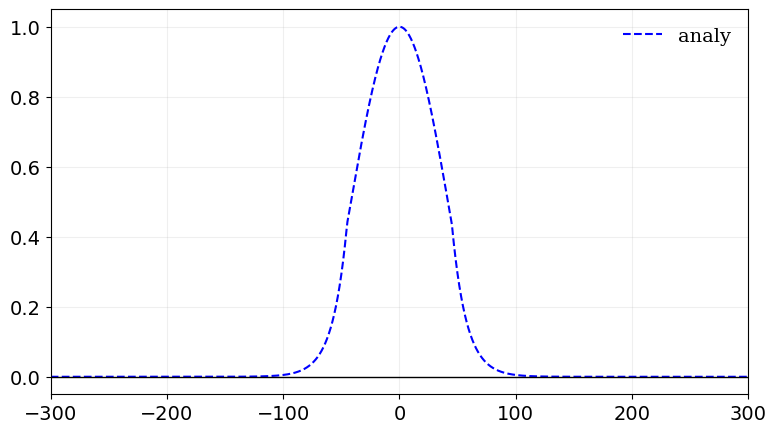

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Constants
V0 = 0.131234
L = 90
mW = 0.047422
mB = 0.0602291
k_w = np.sqrt(mW / 3.809982143)
k_b = np.sqrt(mB / 3.809982143)
d = 90  # Adjusted to the proper value

E=0.02847
V_0 = abs(QW.potential(0,x[int(number_steps/2)]))
d=90
m_w=0.047422
m_b=0.0602291
k_w = np.sqrt(m_w*E/(3.809982143))
print(k_w)
k_b = np.sqrt(m_b*(V_0-E)/(3.809982143))
d = 90

# Functions
def k(x):
    return np.sqrt(mW * x / 3.809982143)

def K(x):
    return np.sqrt(mB * (V0 - x) / 3.809982143)

def analy(x):
    E=0.02847
    V_0 = 0.131234
    d=90
    m_w=0.047422
    m_b=0.0602291
    k_w = np.sqrt(m_w*E/(3.809982143))
    print(k_w)
    k_b = np.sqrt(m_b*(V_0-E)/(3.809982143))
    d = 90
    A=1/(2*(1/k_b * np.cos(k_w*d/2)+ k_w*np.sin(k_w*d/2)))
    print(A)
    B=A*np.cos(k_w*d/2)
    print(B)
    A = 1
    B = A * np.cos(k_w * d / 2)
    y = np.zeros_like(x)
    mask1 = x < -d/2
    mask2 = x > d/2
    mask3 = (~mask1) & (~mask2)  # Ensure mutual exclusivity
    y[mask1] = B * np.exp(-k_b * (-x[mask1] - (d/2)))
    y[mask2] = B * np.exp(-k_b * (x[mask2] - (d/2)))
    y[mask3] = A * np.cos(-k_w * (x[mask3]))
    return y

def analy2(x):
    E=0.12463
    V_0 = 0.131234
    d=90
    m_w=0.047422
    m_b=0.0602291
    k_w = np.sqrt(m_w*E/(3.809982143))
    print(k_w)
    k_b = np.sqrt(m_b*(V_0-E)/(3.809982143))
    d = 90
    A=1
    B=A*np.sin(k_w*d/2)
    A = 1
    B = A*np.sin(k_w * d / 2)
    y = np.zeros_like(x)
    mask1 = x < -d/2
    mask2 = x > d/2
    mask3 = (~mask1) & (~mask2)  # Ensure mutual exclusivity
    y[mask1] = -B * np.exp(-k_b * (-x[mask1] - (d/2)))
    y[mask2] = B * np.exp(-k_b * (x[mask2] - (d/2)))
    y[mask3] = A * np.sin(k_w * (x[mask3]))
    return y

# Generate x values
x_values = np.linspace(-300, 300, 100000)

# Generate y values for each function
y1_values = y1(x_values)
y2_values = y2(x_values)
y3_values = y3(x_values)
analy_values = analy(x_values)
analy2_values = analy2(x_values)

# Plotting
plt.figure(figsize=(9, 5))

plt.plot(x_values, analy_values**2, color='blue', linestyle='--', label='analy')
#plt.plot(x_values, analy2_values**2, color='red', linestyle='-.', label='analy2')

plt.axhline(0, color='black', linewidth=1)  # Solid black x-axis at y=0
plt.xlim(-300, 300)  # Set x-axis limits
plt.ylim()  # Set y-axis limits
plt.grid(True, alpha=0.2)
TICK_FONT_SIZE = 14
plt.xticks(fontsize=TICK_FONT_SIZE)
plt.yticks(fontsize=TICK_FONT_SIZE)

# Set font family and size for legend
font = FontProperties(family='serif', size=14)
plt.legend(loc='upper right', prop=font, frameon=False)

plt.show()


C:\Users\jmcc0\AppData\Local\Temp\ipykernel_21628\1108044803.py:26: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mW * x / 3.809982143)
C:\Users\jmcc0\AppData\Local\Temp\ipykernel_21628\1108044803.py:29: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mB * (V0 - x) / 3.809982143)


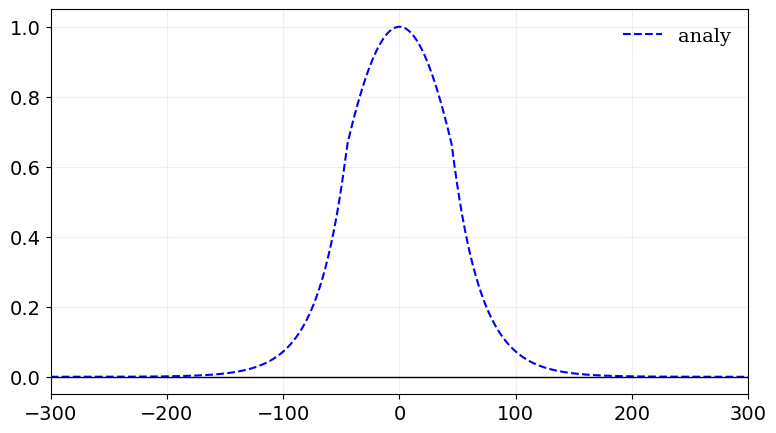

In [75]:
from scipy.integrate import simps
from scipy.integrate import simps

# Normalizing function analy
def analy(x):
    E=0.02847
    V_0 = 0.131234
    d=90
    m_w=0.047422
    m_b=0.0602291
    k_w = np.sqrt(m_w*E/(3.809982143))
    k_b = np.sqrt(m_b*(V_0-E)/(3.809982143))
    d = 90
    A=1
    B=A*np.cos(k_w*d/2)
    A = 1
    B = A * np.cos(k_w * d / 2)
    y = np.zeros_like(x)
    mask1 = x < -d/2
    mask2 = x > d/2
    mask3 = (~mask1) & (~mask2)  # Ensure mutual exclusivity
    y[mask1] = B * np.exp(-k_b * (-x[mask1] - (d/2)))
    y[mask2] = B * np.exp(-k_b * (x[mask2] - (d/2)))
    y[mask3] = A * np.cos(-k_w * (x[mask3]))

    return y

# Normalizing function analy2
def analy2(x):
    E = 0.12463
    V_0 = 0.131234
    d = 90
    m_w = 0.047422
    m_b = 0.0602291
    k_w = np.sqrt(m_w * E / (3.809982143))
    k_b = np.sqrt(m_b * (V_0 - E) / (3.809982143))
    d = 90
    A = 1
    B = A * np.sin(k_w * d / 2)
    y = np.zeros_like(x)
    mask1 = x < -d/2
    mask2 = x > d/2
    mask3 = (~mask1) & (~mask2)  # Ensure mutual exclusivity
    y[mask1] = -B * np.exp(-k_b * (-x[mask1] - (d / 2)))
    y[mask2] = B * np.exp(-k_b * (x[mask2] - (d / 2)))
    # Limit the range of x for which the exponential term is calculated
    y[~mask1 & ~mask2] = A * np.sin(k_w * (x[~mask1 & ~mask2]))
    return y
# Generate x values
x_values = np.linspace(-300, 300, 100000)

# Generate y values for each function
y1_values = y1(x_values)
y2_values = y2(x_values)
y3_values = y3(x_values)
analy_values = analy(x_values)
analy2_values = analy2(x_values)

from scipy.integrate import simps

# Generate x values
x_values = np.linspace(-300, 300, 100000)
# Generate y values for analy2
analy2_values = analy2(x_values)
# Calculate the integral of analy2 using Simpson's rule

integral2 = simps(analy_values, x_values)
# Normalize analy2 by dividing each value by the integral
# analy2_normalized = analy2_values / integral
analy_normalized = analy_values


# Plotting
plt.figure(figsize=(9, 5))

plt.plot(x_values, analy_normalized, color='blue', linestyle='--', label='analy')
#plt.plot(x_values, analy2_normalized, color='red', linestyle='-.', label='analy2')

plt.axhline(0, color='black', linewidth=1)  # Solid black x-axis at y=0
plt.xlim(-300, 300)  # Set x-axis limits
plt.ylim()  # Set y-axis limits
plt.grid(True, alpha=0.2)
TICK_FONT_SIZE = 14
plt.xticks(fontsize=TICK_FONT_SIZE)
plt.yticks(fontsize=TICK_FONT_SIZE)

# Set font family and size for legend
font = FontProperties(family='serif', size=14)
plt.legend(loc='upper right', prop=font, frameon=False)

plt.show()


C:\Users\jmcc0\AppData\Local\Temp\ipykernel_21628\4280227715.py:23: RuntimeWarning: invalid value encountered in sqrt
  k_b = np.sqrt(mB * (V_0 - E) / 3.809982143)
C:\Users\jmcc0\AppData\Local\Temp\ipykernel_21628\4280227715.py:37: RuntimeWarning: invalid value encountered in sqrt
  k_b = np.sqrt(mB * (V_0 - E) / 3.809982143)


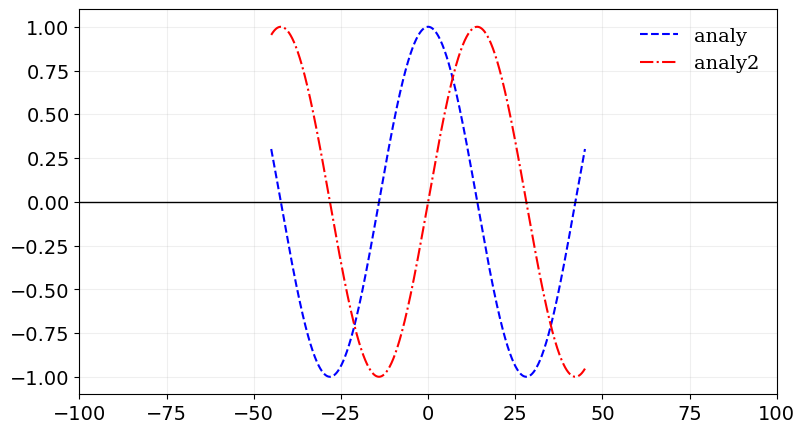

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Constants
V0 = 0.131234
L = 90
mW = 0.047422
mB = 0.0602291
k_w = np.sqrt(mW / 3.809982143)
k_b = np.sqrt(mB / 3.809982143)
d = 90  # Adjusted to the proper value

# Functions
def k(x):
    return np.sqrt(mW * x / 3.809982143)

def K(x):
    return np.sqrt(mB * (V0 - x) / 3.809982143)

def analy(x, E):
    V_0 = abs(QW.potential(0,x[int(number_steps/2)]))  # Adjust as needed
    k_b = np.sqrt(mB * (V_0 - E) / 3.809982143)
    A = 1
    B = A * np.cos(k_w * d / 2)
    y = np.zeros_like(x)
    mask1 = x < -d/2
    mask2 = x > d/2
    mask3 = (~mask1) & (~mask2)  # Ensure mutual exclusivity
    y[mask1] = B * np.exp(-k_b * (-x[mask1] - (d/2)))
    y[mask2] = B * np.exp(-k_b * (x[mask2] - (d/2)))
    y[mask3] = A * np.cos(-k_w * (x[mask3]))
    return y

def analy2(x, E):
    V_0 = abs(QW.potential(0,x[int(number_steps/2)]))  # Adjust as needed
    k_b = np.sqrt(mB * (V_0 - E) / 3.809982143)
    A = 1
    B = A * np.sin(k_w * d / 2)
    y = np.zeros_like(x)
    mask1 = x < -d/2
    mask2 = x > d/2
    mask3 = (~mask1) & (~mask2)  # Ensure mutual exclusivity
    y[mask1] = -B * np.exp(-k_b * (-x[mask1] - (d/2)))
    y[mask2] = B * np.exp(-k_b * (x[mask2] - (d/2)))
    y[mask3] = A * np.sin(k_w * (x[mask3]))
    return y

# Generate x values
x_values = np.linspace(-200, 200, 10000)

# Generate y values for each function
E1 = 0.02847
E2 = 0.12463
analy_values = analy(x_values, E1)
analy2_values = analy2(x_values, E2)

# Plotting
plt.figure(figsize=(9, 5))

plt.plot(x_values, analy_values, color='blue', linestyle='--', label='analy')
plt.plot(x_values, analy2_values, color='red', linestyle='-.', label='analy2')

plt.axhline(0, color='black', linewidth=1)  # Solid black x-axis at y=0
plt.xlim(-100, 100)  # Set x-axis limits
plt.ylim()  # Set y-axis limits
plt.grid(True, alpha=0.2)
TICK_FONT_SIZE = 14
plt.xticks(fontsize=TICK_FONT_SIZE)
plt.yticks(fontsize=TICK_FONT_SIZE)

# Set font family and size for legend
font = FontProperties(family='serif', size=14)
plt.legend(loc='upper right', prop=font, frameon=False)

plt.show()


In [41]:
number_steps = 1000
M = np.zeros((number_steps, number_steps))
x = np.zeros(number_steps)
p=2
delta_x = QW.heterostructure_thickness / (number_steps + 1.0)
C = hbar_squared_2m * 1.0/(delta_x*delta_x)

x[0] = delta_x

alpha_w = np.zeros(number_steps)
alpha_e = np.zeros(number_steps)
alpha_x = np.zeros(number_steps)

particle = ['e', 'lh', 'hh']
#for r in range(11):
electric_field = 0.0

alpha_w[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[0]))
alpha_e[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[1]))
alpha_x[0] = -alpha_w[0]-alpha_e[0]

M[0][0] = alpha_x[0] + QW.potential(p,x[0])
M[0][1] = alpha_e[0]

for nr in range(0, number_steps):
    x[nr] = x[0] + nr*delta_x

for nr in range(1, number_steps-1): #range runs from 1 to num_steps-2 (stupid python syntax)
    alpha_w[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr-1]))
    alpha_e[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr+1]))
    alpha_x[nr] = -alpha_w[nr]-alpha_e[nr]

    M[nr][nr-1] = alpha_w[nr]    #sub-diagonal
    M[nr][nr] = alpha_x[nr] + QW.potential(p,x[nr]) #diagonal
    M[nr][nr+1] = alpha_e[nr]   #upper diagonal 

alpha_w[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1-1]))
alpha_e[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1])) # assuming m(x_edge-dx) = m(x_edge) as boundary condition
alpha_x[number_steps-1] = -alpha_w[number_steps-1]-alpha_e[number_steps-1]
M[number_steps-1][number_steps-2] = alpha_w[number_steps-1]
M[number_steps-1][number_steps-1] = alpha_x[number_steps-1] + QW.potential(p,x[number_steps-1])

w,v=eig(M)
idx = np.argsort(w)
w = w[idx]
v = v[:,idx]

_1 = w[0]

print(M)

pot_e = np.zeros(number_steps)
for nr in range(0, number_steps):
    pot_e[nr] = QW.potential(p, x[nr])
LEGEND=False
en = make_array(E_1, number_steps)
en2 = make_array(E_2, number_steps)

plot_graphs(x,[pot_e, en, en2])
print("Eigenvalue: " + str(w[0]))
eigenVector = v[:,0]
EV_1 = eigenVector
eigenVector2 = np.zeros(number_steps)
eigenVector2 = v[:,1]
clear_output()
plot_graph(x,eigenVector**2)
u = (_1)
u_2 = w[1]


# Analytic Solution

E=0.02847
V_0 = abs(QW.potential(0,x[int(number_steps/2)]))

m_w=0.047422
m_b=0.0602291
k_w = np.sqrt(m_w*E/(3.809982143))
print(k_w)
k_b = np.sqrt(m_b*(V_0-E)/(3.809982143))

A=1
B=A*np.cos(k_w*d/2)
print(B)

y_exact = np.zeros(number_steps)
print(number_steps)
L = QW.heterostructure_thickness
print(L)
x_new=np.zeros(number_steps)
d = 110
count=0
for i in range(number_steps):
    x_new[i] = x[i]-L/2
    if x_new[i] < -d/2:
        y_exact[i] = B*np.exp(-k_b*(-x_new[i]-(d/2)))
    if x_new[i] > d/2:
        y_exact[i] = B*np.exp(-k_b*(x_new[i]-(d/2)))
    elif x_new[i] < d/2 and x_new[i] > -(d/2):
        y_exact[i] = A*np.cos(k_w*(x_new[i]))
    x_new[i] = x[i]
    
# y_exact *= y_exact
for i in range(len(y_exact)):
    count+=y_exact[i]
y_exact /= count
print(len(y_exact))
plot_graphs(x_new, [y_exact,eigenVector])

count = 0
for i in range(number_steps):
    x_new[i] = x[i]-L/2
    if x_new[i] < -d/2:
        y_exact[i] = B*np.exp(-k_b*(-x_new[i]-(d/2)))
    if x_new[i] > d/2:
        y_exact[i] = B*np.exp(-k_b*(x_new[i]-(d/2)))
    elif x_new[i] < d/2 and x_new[i] > -(d/2):
        y_exact[i] = A*np.cos(k_w*(x_new[i]))
    x_new[i] = x[i]

y_exact *= y_exact
for i in range(len(y_exact)):
    count+=y_exact[i]
y_exact /= count
print(len(y_exact))
plot_graphs(x_new, [y_exact,eigenVector**2])

# Analytic Solution

E=0.105
V_0 = abs(QW.potential(0,x[int(number_steps/2)]))
m_w=0.047422
m_b=0.0602291
k_w = np.sqrt(m_w*E/(3.809982143))
print(k_w)
k_b = np.sqrt(m_b*(V_0-E)/(3.809982143))

A=1
B=A*np.sin(k_w*d/2)
print(B)

y_exact = np.zeros(number_steps)
print(number_steps)
L = QW.heterostructure_thickness
print(L)
x_new=np.zeros(number_steps)
d = 110

for i in range(number_steps):
    x_new[i] = x[i]-L/2
    if x_new[i] < -d/2:
        y_exact[i] = -B*np.exp(-k_b*(-x_new[i]-(d/2)))
    if x_new[i] > d/2:
        y_exact[i] = B*np.exp(-k_b*(x_new[i]-(d/2)))
    elif x_new[i] < d/2 and x_new[i] > -(d/2):
        y_exact[i] = A*np.sin(k_w*(x_new[i]))
    x_new[i] = x[i]

count = 0
# y_exact *= y_exact
for i in range(len(y_exact)):
    count+=y_exact[i]
y_exact /= count
print(len(y_exact))
plot_graphs(x_new, [y_exact, eigenVector2])

for i in range(number_steps):
    x_new[i] = x[i]-L/2
    if x_new[i] < -d/2:
        y_exact[i] = -B*np.exp(-k_b*(-x_new[i]-(d/2)))
    if x_new[i] > d/2:
        y_exact[i] = B*np.exp(-k_b*(x_new[i]-(d/2)))
    elif x_new[i] < d/2 and x_new[i] > -(d/2):
        y_exact[i] = A*np.sin(k_w*(x_new[i]))
    x_new[i] = x[i]

count = 0
y_exact *= y_exact
for i in range(len(y_exact)):
    count+=y_exact[i]
y_exact /= count
print(len(y_exact))
plot_graphs(x_new, [y_exact,eigenVector2**2])



[[196.89733555 -98.44866777   0.         ...   0.           0.
    0.        ]
 [-98.44866777 196.89733555 -98.44866777 ...   0.           0.
    0.        ]
 [  0.         -98.44866777 196.89733555 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 196.89733555 -98.44866777
    0.        ]
 [  0.           0.           0.         ... -98.44866777 196.89733555
  -98.44866777]
 [  0.           0.           0.         ...   0.         -98.44866777
  196.89733555]]


NameError: name 'E_1' is not defined

In [114]:
echo

ECHO is on.


<Figure size 600x600 with 0 Axes>

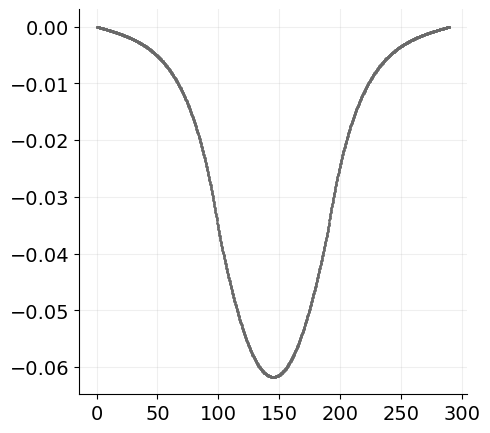

1.0000000000000004


<Figure size 500x500 with 0 Axes>

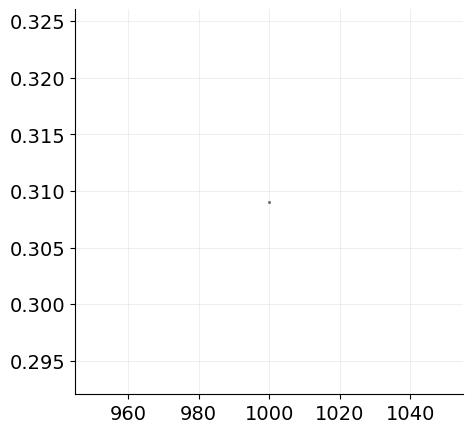

<Figure size 500x500 with 0 Axes>

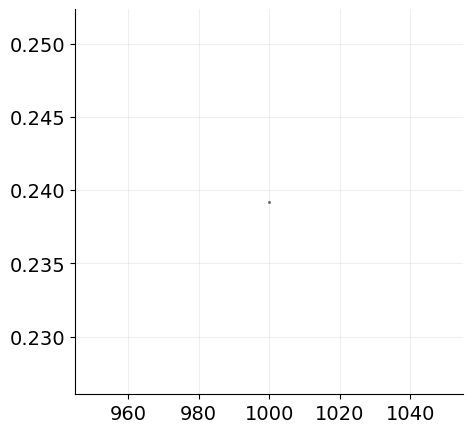

1.0000000000000004


In [90]:
# Solution to Finite Potential Well (Schrodinger Equation in 1D: Finite Potential Within an Infinite Well)
z=[]
y=[]
l=[]
p = 0 # p = 0 : ELECTRON CALCULATION TEST
# for i in range(2,250):
print(i)
number_steps = 1000
M = np.zeros((number_steps, number_steps))
x = np.zeros(number_steps)

dy = 1.0 / QW.heterostructure_thickness


delta_x = QW.heterostructure_thickness / (number_steps + 1.0)
C = hbar_squared_2m * 1.0/(delta_x*delta_x)

x[0] = delta_x

alpha_w = np.zeros(number_steps)
alpha_e = np.zeros(number_steps)
alpha_x = np.zeros(number_steps)

particle = ['e', 'lh', 'hh']

electric_field = 0.000

alpha_w[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[0]))
alpha_e[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[1]))
alpha_x[0] = -alpha_w[0]-alpha_e[0]

M[0][0] = alpha_x[0] + QW.potential(p,x[0])
M[0][1] = alpha_e[0]

for nr in range(0, number_steps):
    x[nr] = x[0] + nr*delta_x

for nr in range(1, number_steps-1): #range runs from 1 to num_steps-2 (stupid python syntax)
    alpha_w[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr-1]))
    alpha_e[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr+1]))
    alpha_x[nr] = -alpha_w[nr]-alpha_e[nr]

    M[nr][nr-1] = alpha_w[nr]    #sub-diagonal
    M[nr][nr] = alpha_x[nr] + QW.potential(p,x[nr]) #diagonal
    M[nr][nr+1] = alpha_e[nr]   #upper diagonal 

alpha_w[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1-1]))
alpha_e[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1])) # assuming m(x_edge-dx) = m(x_edge) as boundary condition
alpha_x[number_steps-1] = -alpha_w[number_steps-1]-alpha_e[number_steps-1]
M[number_steps-1][number_steps-2] = alpha_w[number_steps-1]
M[number_steps-1][number_steps-1] = alpha_x[number_steps-1] + QW.potential(p,x[number_steps-1])

w,v=eig(M)
idx = np.argsort(w)
w = w[idx]
v = v[:,idx]

_1 = w[0]

print(M)

pot_e = np.zeros(number_steps)
for nr in range(0, number_steps):
    pot_e[nr] = QW.potential(p, x[nr])
LEGEND=False

plot_graphs(x,[pot_e])
print("Eigenvalue: " + str(w[0]))
eigenVector = v[:,0]
EV_1 = eigenVector
clear_output()
plot_graph(x,eigenVector)
print(sum(eigenVector**2))
u = (_1)
u_2 = w[1]
y.append(abs(((u+0.1312346410044991-0.02847))/0.02847))
z.append(number_steps)
l.append(abs(((u_2+0.1312346410044991-0.105))/0.105))

plot_graph(z, y)
plot_graph(z, l)
print(sum(eigenVector**2))

In [184]:
abs(((u-QW.potential(p, x[700]))-0.02847))/0.02847

0.016546947059910864

<Figure size 900x900 with 0 Axes>

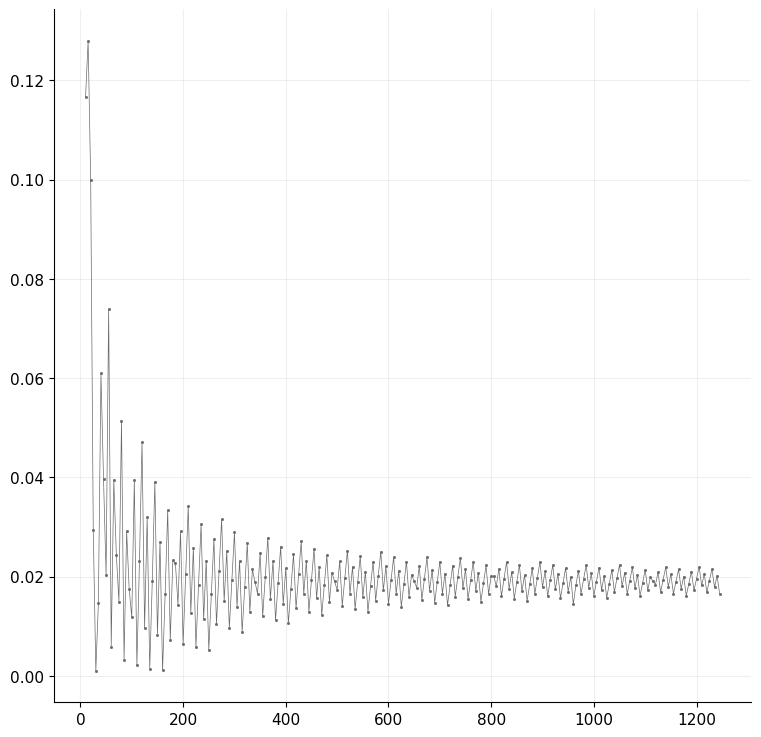

<Figure size 900x900 with 0 Axes>

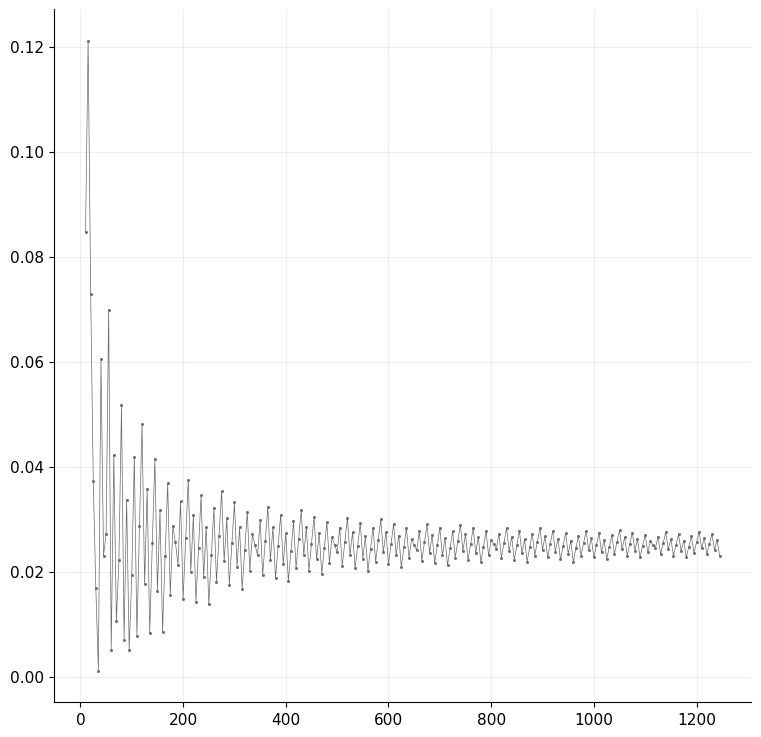

In [197]:
plot_graph(z, y)
plot_graph(z, l)

In [452]:
def relative_energy(energy, p): # accept a 2 paramters [energy relative to well of..][particle type]
    # corrects an (inital) calculated energy from QW solution for respective band of type particle type p
    EF_offset = electron_charge*electric_field*QW.heterostructure_thickness
    BG = min(abs(layers[i].material.band_gap) for i in range (0, len(layers)-1)) # this should be okay with and without override on    
    if(p==0):
        if over_ride_offsets == True:
            E_REL = energy + BG + max(abs(CBO_override[i]) for i in range(0, len(layers)-1))
        else:
            E_REL = energy + BG + max(abs(CBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1))
    elif(p==1 or p==2):
        if over_ride_offsets == True:
            E_REL = -max(abs(VBO_override[i]) for i in range(0, len(layers)-1)) - energy + EF_offset
        else:
            E_REL = -max(abs(VBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1)) - energy + EF_offset
    return E_REL

def find_transitions(energies): # accept a SORTED 2 Dimensional matrix [3][number_solutions] ... 
    E_gap = np.zeros((number_steps, number_steps, 2))
    for k in range(2): # for 2 hole types
        for i in range(len(energies)): # for all electrons
            for j in range(len(energies)): # and all hole states
                E_gap[i][j][k] = abs(energies[0][i]-energies[k+1][j])
    return E_gap # a matrix/array of energy transtions indexed as [electron state][hole state][hole type] 

def find_energies_relative(energies): # accept a 2 Dimensional matrix [3][number_solutions]
    energies_relative = np.zeros((3, number_steps))
    for k in range(3): # for 3 particle types
        for i in range(len(energies)): # for all states
            energies_relative[k][i] = relative_energy(energies[k][i], k)
    return energies_relative # returns [3][number_solutions] matrix of energies relative to their ectual value in well structure

def overlap_integral(vector1, vector2):    # S = <v_1|v_2> | accept only vectors of same length
    overlap = np.zeros(len(vector1))       # assuming both are the same length
    N1 = sum(abs(vector1)**2)              # Normalisation constant N = <v|v>
    N2 = sum(abs(vector2)**2)
    # print("N1 = {}".format(N1))
    # print("N2 = {}".format(N2))
    vector1_dummy = vector1 / N1           # normalise wavefunctions (N^-1)|v>
    vector2_dummy = vector2 / N2
    for i in range(len(vector1)):
        overlap[i] = (vector1_dummy[i]*vector2_dummy[i]) 
    return overlap                         # I = <v_1|v_2>

def I_squared(vector1, vector2):           # S = <v_1|v_2> | accept only vectors of same length
    overlap = overlap_integral(vector1, vector2)
    I_squared = sum(abs(overlap))**2
    return I_squared            # I^2 = |<v_1|v_2>|^2


In [182]:
QW.potential(p, x[700])

-0.1312346410044991

In [528]:
number_steps = 500
M = np.zeros((number_steps, number_steps))
x = np.zeros(number_steps)
p=2
delta_x = QW.heterostructure_thickness / (number_steps + 1.0)
C = hbar_squared_2m * 1.0/(delta_x*delta_x)
BG=layer3.material.band_gap
print(BG)
x[0] = delta_x
BG_=[]

eigenvectors_all = []
eigenvectors = [[0]*number_steps for _ in range(3)]

alpha_w = np.zeros(number_steps)
alpha_e = np.zeros(number_steps)
alpha_x = np.zeros(number_steps)

energies = np.zeros((3,11))
e_fields = np.zeros(11)
particle = ['e', 'lh', 'hh']

for r in range(11):
    eigenvectors = [[0]*number_steps for _ in range(3)]
    electric_field = 0.0001*r
    e_fields[r]=electric_field
    vectors=np.zeros((3,number_steps))
    for p in range(3):
        alpha_w[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[0]))
        alpha_e[0] = -C*2.0/(QW.eff_mass(particle[p],x[0])+QW.eff_mass(particle[p],x[1]))
        alpha_x[0] = -alpha_w[0]-alpha_e[0]

        M[0][0] = alpha_x[0] + QW.potential(p,x[0])
        M[0][1] = alpha_e[0]

        for nr in range(0, number_steps):
            x[nr] = x[0] + nr*delta_x

        for nr in range(1, number_steps-1): #range runs from 1 to num_steps-2 (stupid python syntax)
            alpha_w[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr-1]))
            alpha_e[nr] = - C*2.0/(QW.eff_mass(particle[p],x[nr])+QW.eff_mass(particle[p],x[nr+1]))
            alpha_x[nr] = -alpha_w[nr]-alpha_e[nr]

            M[nr][nr-1] = alpha_w[nr]    #sub-diagonal
            M[nr][nr] = alpha_x[nr] + QW.potential(p,x[nr]) #diagonal
            M[nr][nr+1] = alpha_e[nr]   #upper diagonal 

        alpha_w[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1-1]))
        alpha_e[number_steps-1] = - C*2.0/(QW.eff_mass(particle[p],x[number_steps-1])+QW.eff_mass(particle[p],x[number_steps-1])) # assuming m(x_edge-dx) = m(x_edge) as boundary condition
        alpha_x[number_steps-1] = -alpha_w[number_steps-1]-alpha_e[number_steps-1]
        M[number_steps-1][number_steps-2] = alpha_w[number_steps-1]
        M[number_steps-1][number_steps-1] = alpha_x[number_steps-1] + QW.potential(p,x[number_steps-1])

        w,v=eig(M)
        idx = np.argsort(w)
        w = w[idx]
        v = v[:,idx]
        print(str(r)+" "+str(p)+" "+str(w[0]))
        _1 = w[0]
        energies[p][r] = w[0]

        pot_e = np.zeros(number_steps)
        for nr in range(0, number_steps):
            pot_e[nr] = QW.potential(p, x[nr])
        LEGEND=False
        en = make_array(E_1, number_steps)
        en2 = make_array(E_2, number_steps)

        #plot_graphs(x,[pot_e, en, en2])
        print("Eigenvalue: " + str(w[0]))
        eigenVector = v[:,0]
        EV_1 = eigenVector
        np.append(vectors[p][r],EV_1)
        eigenVector2 = np.zeros(number_steps)
        eigenVector2 = v[:,1]
        #plot_graph(x,eigenVector**2)
        u = (_1)
        u_2 = w[1]
        eigenvectors[p]=v[:, 0]
                        
    eigenvectors_all.append(eigenvectors)
    print("BANDGAP:"+str((energies[0][r]+abs(QW.potential(0,x[int(number_steps/2)])))+BG+(energies[2][r]+abs(QW.potential(2,x[int(number_steps/2)])))))
    BG_.append((energies[0][r]+abs(QW.potential(0,x[int(number_steps/2)])))+BG+(energies[2][r]+abs(QW.potential(2,x[int(number_steps/2)]))))
    #clear_output()
print("done")

0.8000976225011801
0 0 -0.08532383005935118
Eigenvalue: -0.08532383005935118
0 1 -0.03793516703329111
Eigenvalue: -0.03793516703329111
0 2 -0.06040922196292939
Eigenvalue: -0.06040922196292939
BANDGAP:0.8543868856816111
1 0 -0.08539562060606969
Eigenvalue: -0.08539562060606969
1 1 -0.03810291348052745
Eigenvalue: -0.03810291348052745
1 2 -0.06054571998814955
Eigenvalue: -0.06054571998814955
BANDGAP:0.8541785971096725
2 0 -0.08561170066439831
Eigenvalue: -0.08561170066439831
2 1 -0.038611527080727945
Eigenvalue: -0.038611527080727945
2 2 -0.06095176004537288
Eigenvalue: -0.06095176004537288
BANDGAP:0.8535564769941204
3 0 -0.08597424518404184
Eigenvalue: -0.08597424518404184
3 1 -0.03947755084261921
Eigenvalue: -0.03947755084261921
3 2 -0.06161773087389226
Eigenvalue: -0.06161773087389226
BANDGAP:0.8525279616459576
4 0 -0.08648705006299495
Eigenvalue: -0.08648705006299495
4 1 -0.040729858168317486
Eigenvalue: -0.040729858168317486
4 2 -0.06252989250510492
Eigenvalue: -0.06252989250510492

<Figure size 500x500 with 0 Axes>

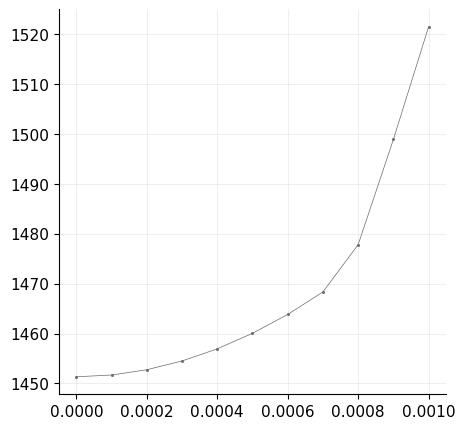

-0.13096018990669472


-0.06906212529601685

In [529]:
QW.potential(2,x[int(number_steps/2)])
    
plot_graph(e_fields, h_c/np.array(BG_))
print(QW.potential(0,x[int(number_steps/2)]))
QW.potential(2,x[int(number_steps/2)])

<Figure size 500x500 with 0 Axes>

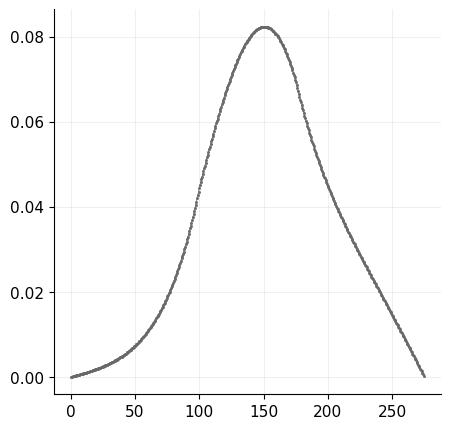

0.9186944832000947
0.9109264957154906
0.8883524708335475
0.8529463580758258
0.8073910184583183
0.7544567607664776
0.6963631439842582
0.631382489651915
0.046517940212173974
0.0035843138103509543
0.0013105427338879426


NameError: name 'x_min' is not defined

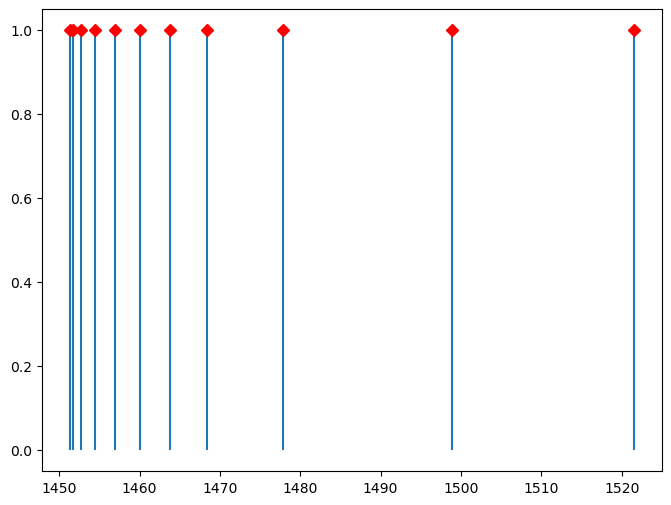

In [531]:
y=eigenvectors = [[] for _ in range(11)]
plot_graph(x,eigenvectors_all[4][1])
for r in range(11):
    y[r]=I_squared(eigenvectors_all[r][2],eigenvectors_all[r][0])
    print(y[r])

x_range=[1400,1700]
num_points=1000
x_values = np.linspace(x_range[0], x_range[1], num_points)

# Array of positions where you want to plot deltas
positions = np.array(h_c/np.array(BG_))
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the deltas
plt.stem(positions, np.ones_like(positions), linefmt='-', markerfmt='rD', basefmt=' ')

# Set x-axis limits
plt.xlim(x_min, x_max)

# Set labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Plotting Deltas at Specified Positions')

# Show plot
plt.grid(True)
plt.show()

0.8952048731449093
0.8913729353950862
0.8799822724419506
0.8613320039773749
0.8358670867212372
0.8040905124996036
0.7663036308077691
0.7187638410580801
0.06049648719661485
0.006098349154153917
0.0024806096553639826


ValueError: x and y must have same first dimension, but have shapes (1000,) and (11,)

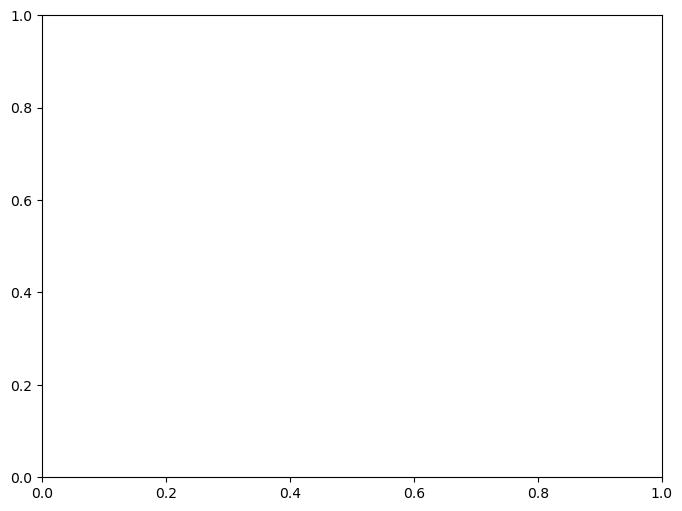

In [526]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already defined eigenvectors_all and other necessary variables

# Calculate y-values based on eigenvectors
y = []
for r in range(11):
    y.append(I_squared(eigenvectors_all[r][0], eigenvectors_all[r][2]))
    print(y[r])

# Define the range and the number of points
x_range = [1400, 1700]
num_points = 1000

# Discretize the x-axis
x_values = np.linspace(x_range[0], x_range[1], num_points)

# Array of positions where you want to plot deltas
positions = np.array(h_c / np.array(BG_))

# Create a plot
plt.figure(figsize=(8, 6))

# Plot the main curve
plt.plot(x_values, y, label='Main Curve')

# Plot the deltas at specified positions
plt.stem(positions, np.ones_like(positions), linefmt='-', markerfmt='rD', basefmt=' ')

# Set labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Plotting Main Curve with Deltas at Specified Positions')

# Show plot
plt.grid(True)
plt.legend()
plt.show()
